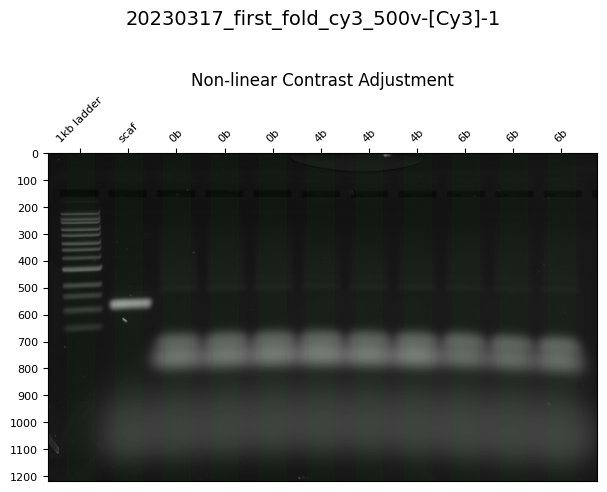

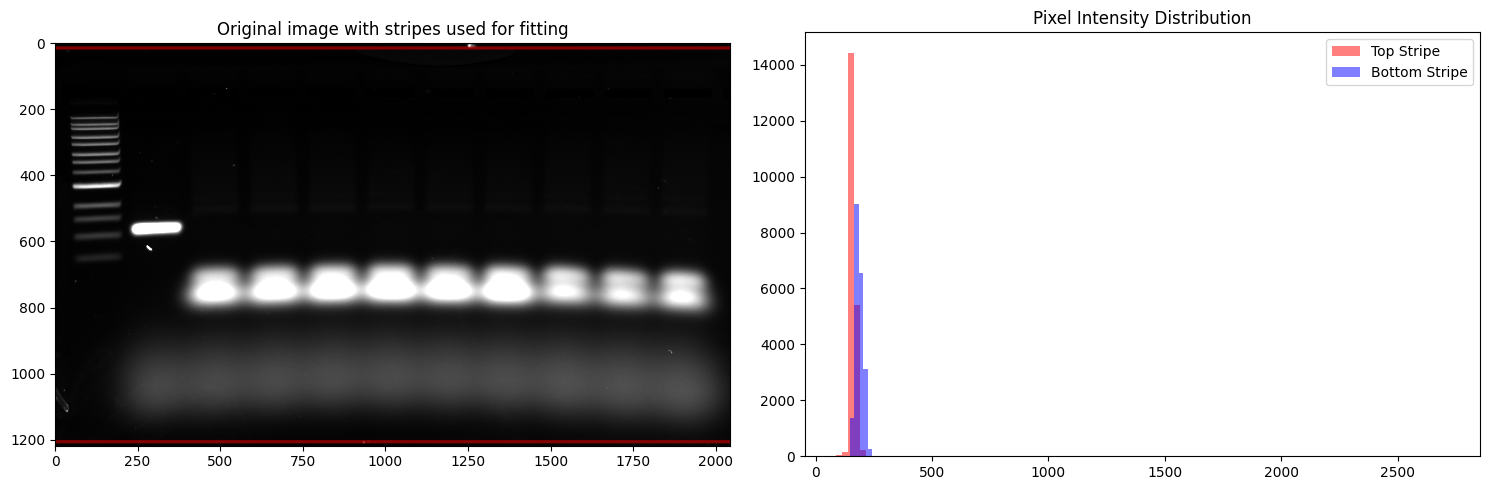

/home/ckarfusehr/anaconda3/envs/gelpy/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


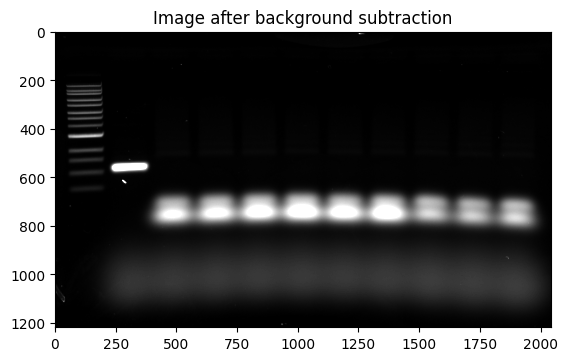

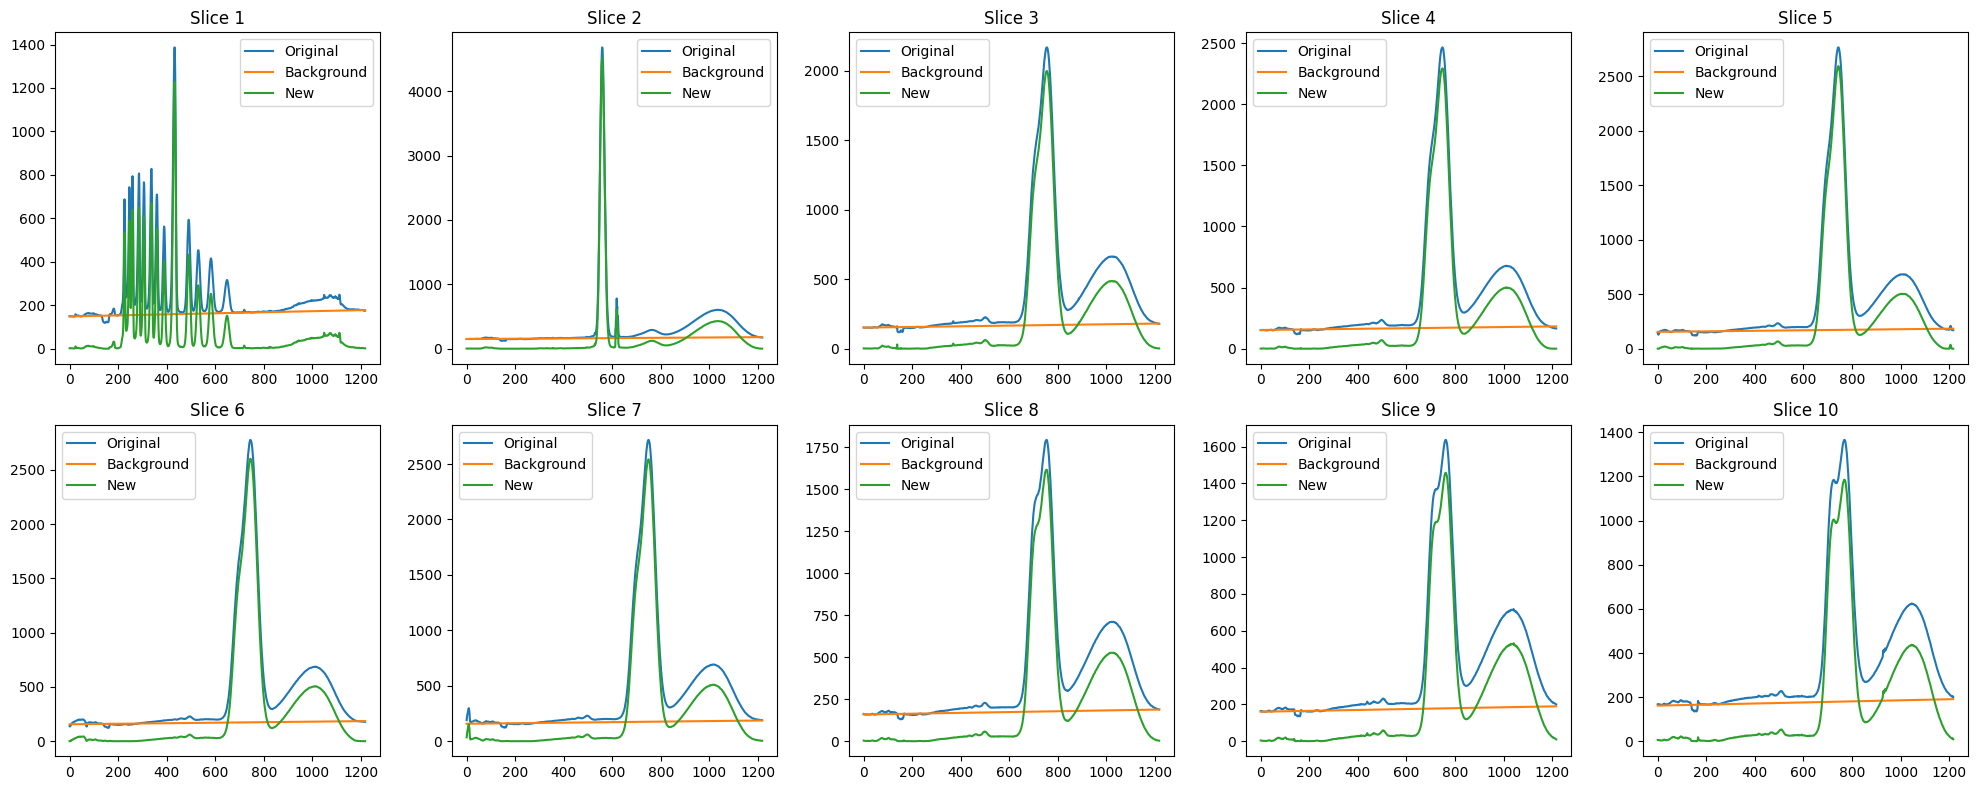

In [1]:
from gelpy import AgaroseGel

gel = AgaroseGel("data/20230317_first_fold_cy3_500v-[Cy3]-1.tif")
gel.setup_gel(labels=['1kb ladder', 'scaf', '0b', '0b', '0b', '4b', '4b', '4b', '6b', '6b', '6b'], x_label_pos=(120, 1910, 11),
              line_profile_width=100)
gel.remove_background()






# gel.show_adjusted_images()
# gel.show_line_profiles(select_lanes=["0b", "4b"],
#                        slice_line_profile_length=(100, 900),
#                        fit="emg",
#                        maxima_prominence=0.0005, maxima_threshold=0.001,
#                        plot_fits=True)

# image=gel.Image.gel_image
# tbpf = TopBottomPlaneFit(image)
# tbpf.extract_fit_data_from_image(top_stripe_height=10, top_stripe_position=10,
#                                  bottom_stripe_height=10, bottom_stripe_position=1200)
# tbpf.fit_background()
# tbpf.remove_background(show_new_image=True)
# tbpf.visualize_profiles()
# print(sum(tbpf.inlier_mask), len(tbpf.inlier_mask), tbpf.params)

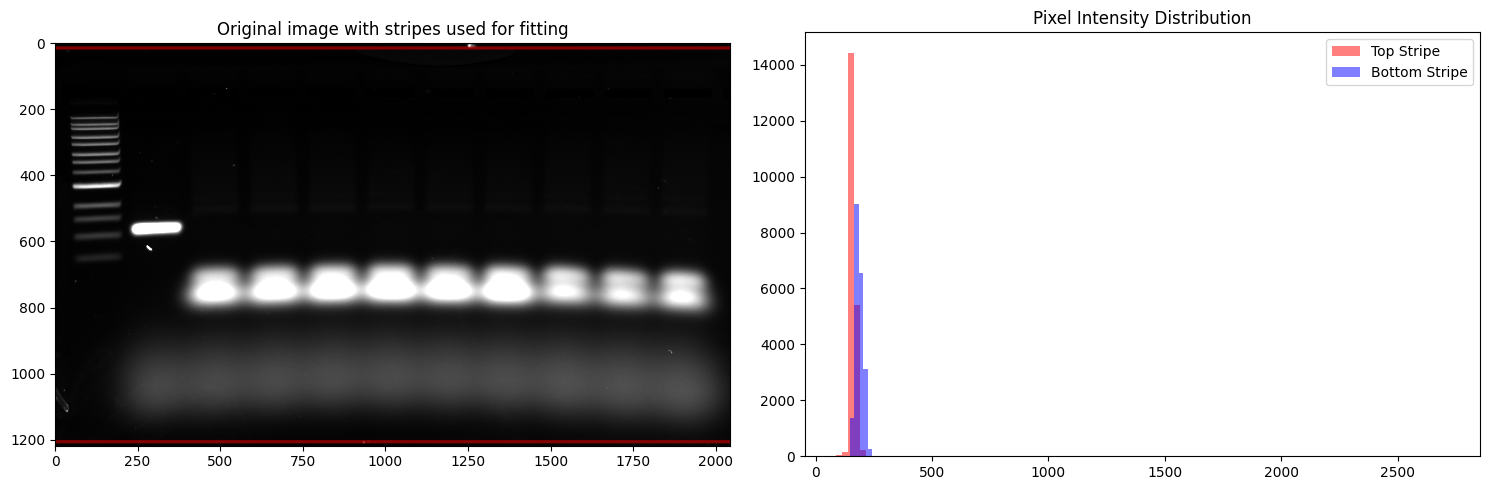

/home/ckarfusehr/anaconda3/envs/gelpy/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


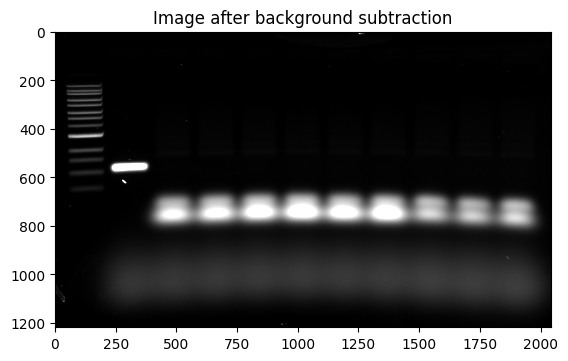

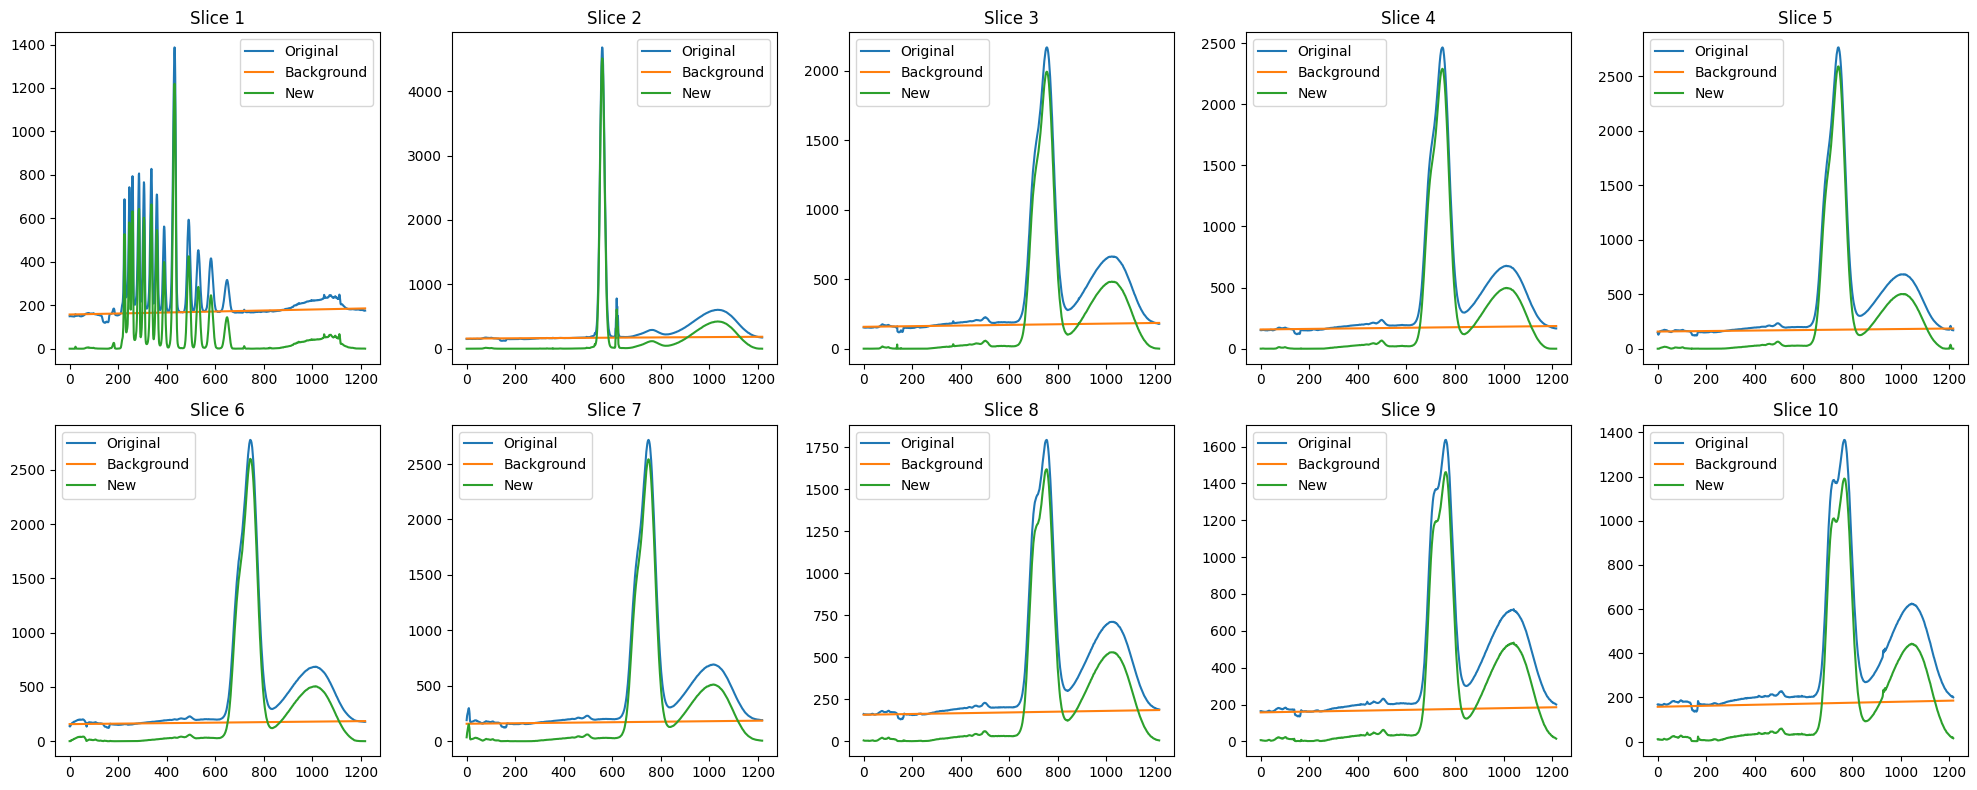

20 20 [0.02302213139585053, 157.4680109142291]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import lstsq
from sklearn.linear_model import RANSACRegressor, LinearRegression

class TopBottomPlaneFit:
    def __init__(self, image):
        self.image = image

    def extract_fit_data_from_image(self, top_stripe_height, top_stripe_position, bottom_stripe_height, bottom_stripe_position):
        top_stripe = self.image[top_stripe_position:top_stripe_position+top_stripe_height, :]
        bottom_stripe = self.image[bottom_stripe_position:bottom_stripe_position+bottom_stripe_height, :]
        
        # Compute median values along the x-axis for each row in the top and bottom stripes
        top_stripe_medians = np.median(top_stripe, axis=1)
        bottom_stripe_medians = np.median(bottom_stripe, axis=1)

        # The corresponding Y coordinates are just the row indices
        Y_top = np.arange(top_stripe_position, top_stripe_position+top_stripe_height)
        Y_bottom = np.arange(bottom_stripe_position, bottom_stripe_position+bottom_stripe_height)

        # Concatenate the median values and their Y coordinate arrays
        self.fit_data = np.concatenate((top_stripe_medians, bottom_stripe_medians))
        self.fit_data_Y = np.concatenate((Y_top, Y_bottom))


        # Debugging: display original image with stripes overlayed in red
        # Create an RGBA image with the same size as the original image
        overlay = np.zeros((self.image.shape[0], self.image.shape[1], 4))

        # Set alpha (transparency) to 0.5 for the stripes, 0 elsewhere
        overlay[top_stripe_position:top_stripe_position+top_stripe_height, :, 3] = 0.5
        overlay[bottom_stripe_position:bottom_stripe_position+bottom_stripe_height, :, 3] = 0.5

        # Set color of the stripes to red
        overlay[:, :, 0] = 1

        # Determine the 2nd and 98th percentiles of the image data
        vmin, vmax = np.percentile(self.image, [2, 98])

        fig, ax = plt.subplots(1, 2, figsize=(15, 5)) # New line to create a subplot

        ax[0].imshow(self.image, cmap='gray', vmin=vmin, vmax=vmax) # Changed from plt.imshow to ax[0].imshow
        ax[0].imshow(overlay)
        ax[0].set_title('Original image with stripes used for fitting')

        # New lines to plot histograms
        #ax[1].hist(self.image.flatten(), bins=100, color='gray', alpha=0.5, label='Entire Image')  # Entire image histogram
        ax[1].hist(top_stripe.flatten(), bins=100, color='red', alpha=0.5, label='Top Stripe')  # Top stripe histogram
        ax[1].hist(bottom_stripe.flatten(), bins=100, color='blue', alpha=0.5, label='Bottom Stripe')  # Bottom stripe histogram
        ax[1].set_title('Pixel Intensity Distribution')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def extract_background(self):
        # Fit line using RANSAC
        ransac = RANSACRegressor(base_estimator=LinearRegression(fit_intercept=True),
                                 random_state=0)
        ransac.fit(self.fit_data_Y.reshape(-1, 1), self.fit_data)

        # Extract the parameters of the fitted line
        self.params = [ransac.estimator_.coef_[0], ransac.estimator_.intercept_]
        self.inlier_mask = ransac.inlier_mask_



    def remove_background(self, show_new_image=False):
        y_len, x_len = self.image.shape
        Y = np.arange(y_len).reshape(-1, 1)
        line_z = self.params[0]*Y + self.params[1]
        line_z_broadcasted = np.broadcast_to(line_z, (y_len, x_len))
        self.new_image = self.image - line_z_broadcasted

        # clipping negative values to zero
        self.new_image[self.new_image < 0] = 0

        if show_new_image:
                    # Determine the 2nd and 98th percentiles of the image data
            vminnew_img, vmaxnew_img = np.percentile(self.new_image, [1, 99])
            plt.imshow(self.new_image, cmap='gray', vmin=vminnew_img, vmax=vmaxnew_img)
            plt.title('Image after background subtraction')
            plt.show()

        return self.new_image
    
    def visualize_profiles(self):
        y_len, x_len = self.image.shape
        Y = np.arange(y_len).reshape(-1, 1)
        bg_line = self.params[0]*Y + self.params[1]  # Reconstruct the background line
        bg_line_broadcasted = np.broadcast_to(bg_line, (y_len, x_len))

        # Compute the new image
        new_image = self.image - bg_line_broadcasted
        new_image[new_image < 0] = 0  # clip negative values to zero

        # Define the slices
        slice_indices = np.linspace(0, x_len, 11).astype(int)  # Returns 11 points, but we will use it as start/end indices for 10 slices

        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust size as needed
        axs = axs.flatten()  # So we can iterate over the axes in a single loop

        for i in range(10):
            start, end = slice_indices[i], slice_indices[i+1]
            original_slice = self.image[:, start:end]
            bg_slice = bg_line_broadcasted[:, start:end]
            new_slice = new_image[:, start:end]  # New line

            # Compute the row-averaged profiles
            original_profile = original_slice.mean(axis=1)
            bg_profile = bg_slice.mean(axis=1)
            new_profile = new_slice.mean(axis=1)  # New line

            # Plot the profiles
            axs[i].plot(original_profile, label='Original')
            axs[i].plot(bg_profile, label='Background')
            axs[i].plot(new_profile, label='New')  # New line
            axs[i].legend()
            axs[i].set_title(f'Slice {i+1}')

        plt.tight_layout()
        plt.show()

    
# Assuming `image` is your grayscale image
image=gel.Image.gel_image
tbpf = TopBottomPlaneFit(image)
tbpf.extract_fit_data_from_image(top_stripe_height=10, top_stripe_position=10,
                                 bottom_stripe_height=10, bottom_stripe_position=1200)
tbpf.extract_background()
new_image = tbpf.remove_background(show_new_image=True)
tbpf.visualize_profiles()
print(sum(tbpf.inlier_mask), len(tbpf.inlier_mask), tbpf.params)

In [3]:
### Ransack plane fit.

# Change such, that the compelte image is used as an input.

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import lstsq
from sklearn.linear_model import RANSACRegressor, LinearRegression

class TopBottomPlaneFit:
    def __init__(self, image):
        self.image = image

    def extract_fit_data_from_image(self, top_stripe_height, top_stripe_position, bottom_stripe_height, bottom_stripe_position):
        top_stripe = self.image[top_stripe_position:top_stripe_position+top_stripe_height, :]
        bottom_stripe = self.image[bottom_stripe_position:bottom_stripe_position+bottom_stripe_height, :]
        
        # Create arrays representing the X and Y coordinates of each pixel in the top and bottom stripes
        X_top, Y_top = np.meshgrid(np.arange(top_stripe.shape[1]), np.arange(top_stripe_position, top_stripe_position+top_stripe_height))
        X_bottom, Y_bottom = np.meshgrid(np.arange(bottom_stripe.shape[1]), np.arange(bottom_stripe_position, bottom_stripe_position+bottom_stripe_height))

        # Concatenate the top and bottom stripes, and their X and Y coordinate arrays
        self.fit_data = np.concatenate((top_stripe.ravel(), bottom_stripe.ravel()))
        self.fit_data_X = np.concatenate((X_top.ravel(), X_bottom.ravel()))
        self.fit_data_Y = np.concatenate((Y_top.ravel(), Y_bottom.ravel()))

    def visualize_fit_data(self, top_stripe_height, top_stripe_position, bottom_stripe_height, bottom_stripe_position):
        # Debugging: display original image with stripes overlayed in red
        # Create an RGBA image with the same size as the original image
        overlay = np.zeros((self.image.shape[0], self.image.shape[1], 4))

        # Set alpha (transparency) to 0.5 for the stripes, 0 elsewhere
        overlay[top_stripe_position:top_stripe_position+top_stripe_height, :, 3] = 0.5
        overlay[bottom_stripe_position:bottom_stripe_position+bottom_stripe_height, :, 3] = 0.5

        # Set color of the stripes to red
        overlay[:, :, 0] = 1

        # Determine the 2nd and 98th percentiles of the image data
        vmin, vmax = np.percentile(self.image, [2, 98])

        fig, ax = plt.subplots(1, 2, figsize=(15, 5)) # New line to create a subplot

        ax[0].imshow(self.image, cmap='gray', vmin=vmin, vmax=vmax) # Changed from plt.imshow to ax[0].imshow
        ax[0].imshow(overlay)
        ax[0].set_title('Original image with stripes used for fitting')

        # New lines to plot histograms
        #ax[1].hist(self.image.flatten(), bins=100, color='gray', alpha=0.5, label='Entire Image')  # Entire image histogram
        ax[1].hist(top_stripe.flatten(), bins=100, color='red', alpha=0.5, label='Top Stripe')  # Top stripe histogram
        ax[1].hist(bottom_stripe.flatten(), bins=100, color='blue', alpha=0.5, label='Bottom Stripe')  # Bottom stripe histogram
        ax[1].set_title('Pixel Intensity Distribution')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def fit_model_to_data(self):
        # Stack X and Y into the data array
        data = np.c_[self.fit_data_X, self.fit_data_Y]

        # Fit plane using RANSAC
        ransac = RANSACRegressor(base_estimator=LinearRegression(fit_intercept=True),
                                 random_state=0)
        ransac.fit(data, self.fit_data)

        # Extract the parameters of the fitted plane
        self.params = [ransac.estimator_.coef_[0], ransac.estimator_.coef_[1], ransac.estimator_.intercept_]
        self.inlier_mask = ransac.inlier_mask_
        
        y_len, x_len = self.image.shape
        X, Y = np.meshgrid(np.arange(x_len), np.arange(y_len))
        self.reconstructed_bg = self.params[0]*X + (self.params[1]/y_len)*Y + self.params[2]
        # reconstruct background img from fit



    def remove_background(self, show_new_image=False):
        self.new_image = self.image - self.reconstructed_bg
        # clipping negative values to zero
        self.new_image[self.new_image < 0] = 0
        
        if show_new_image:
                    # Determine the 2nd and 98th percentiles of the image data
            vminnew_img, vmaxnew_img = np.percentile(self.new_image, [1, 99])
            plt.imshow(self.new_image, cmap='gray', vmin=vminnew_img, vmax=vmaxnew_img)
            plt.title('Image after background subtraction')
            plt.show()
            
        return
    
    def visualize_profiles(self):
        y_len, x_len = self.image.shape
        X, Y = np.meshgrid(np.arange(x_len), np.arange(y_len))
        bg_plane = self.params[0]*X + self.params[1]*Y + self.params[2]  # Reconstruct the background plane

        # Compute the new image
        new_image = self.image - bg_plane
        new_image[new_image < 0] = 0  # clip negative values to zero

        # Define the slices
        slice_indices = np.linspace(0, x_len, 11).astype(int)  # Returns 11 points, but we will use it as start/end indices for 10 slices

        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust size as needed
        axs = axs.flatten()  # So we can iterate over the axes in a single loop

        for i in range(10):
            start, end = slice_indices[i], slice_indices[i+1]
            original_slice = self.image[:, start:end]
            bg_slice = bg_plane[:, start:end]
            new_slice = new_image[:, start:end]  # New line

            # Compute the row-averaged profiles
            original_profile = original_slice.mean(axis=1)
            bg_profile = bg_slice.mean(axis=1)
            new_profile = new_slice.mean(axis=1)  # New line

            # Plot the profiles
            axs[i].plot(original_profile, label='Original')
            axs[i].plot(bg_profile, label='Background')
            axs[i].plot(new_profile, label='New')  # New line
            axs[i].legend()
            axs[i].set_title(f'Slice {i+1}')

        plt.tight_layout()
        plt.show()
    
# Assuming `image` is your grayscale image
image=gel.Image.gel_image
tbpf = TopBottomPlaneFit(image)
tbpf.extract_fit_data_from_image(top_stripe_height=10, top_stripe_position=10,
                                 bottom_stripe_height=10, bottom_stripe_position=1200)
tbpf.fit_background()
tbpf.remove_background(show_new_image=True)
tbpf.visualize_profiles()
print(sum(tbpf.inlier_mask), len(tbpf.inlier_mask), tbpf.params)

AttributeError: 'TopBottomPlaneFit' object has no attribute 'fit_background'

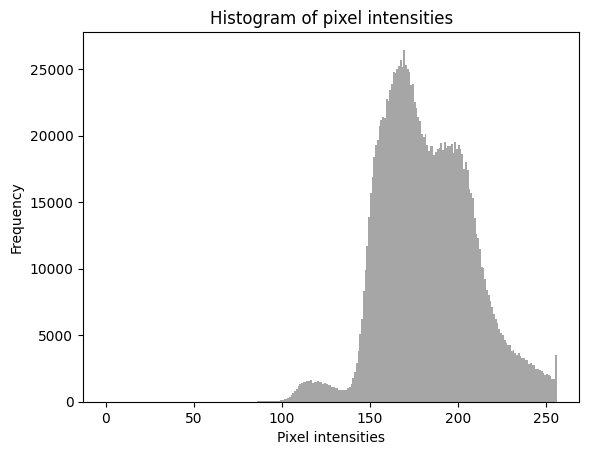

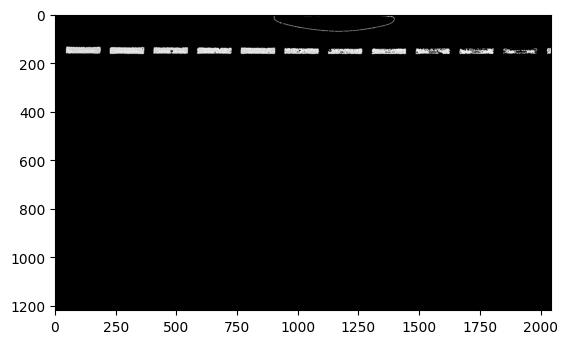

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `image` is your numpy array

# Flatten the image into 1 dimension: change shape (m,n) to (m*n,1)
image=gel.Image.gel_image
pixels = image.flatten()

# Create histogram
plt.hist(pixels, bins=256, range=[0,256], color='gray', alpha=0.7)

plt.title('Histogram of pixel intensities')
plt.xlabel('Pixel intensities')
plt.ylabel('Frequency')
plt.show()

# Assuming `image` is your numpy array
# Setting a threshold
threshold = 130

# Applying the threshold filter
filtered_image = np.where(image < threshold, image, 0)
filtered_image2 = np.where(image >= threshold, image, 0)

# Now, `filtered_image` will only contain pixels with intensities less than the threshold. 
# The intensities of all other pixels are set to 0.

plt.imshow(filtered_image, cmap="gray")
